In [51]:
import os
import uproot
import ROOT as r
import math
import awkward as ak
import hist
from hist import Hist
from hist import loc
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append('/sdf/group/hps/users/alspellm/projects/THESIS/analysis/reach_estimate')
from SimpEquations_validated import SimpEquations as simpeqs
import mpl_plot_utilities as mplutils
from matplotlib.backends.backend_pdf import PdfPages

In [121]:
import ROOT as r

def fitExponentialTail(histo, start_n):
    originalXmin = histo.GetXaxis().GetXmin()
    originalXmax = histo.GetXaxis().GetXmax()
    
    # Start fit where there are n events left in tail
    lastbin = histo.FindLastBinAbove(0.0)
    if histo.Integral() < start_n:
        start_n = histo.GetBinContent(histo.GetMaximumBin())
    firstbin = lastbin - 1
    test_integral = 0.0
    if start_n <= 0:
        return None
    
    while test_integral < start_n and histo.GetBinLowEdge(firstbin) > 0.0:
        test_integral = histo.Integral(firstbin, lastbin)
        firstbin -= 1
        
    #print('test_integral:',test_integral)
    # Set range for fitting
    xmin = histo.GetBinLowEdge(firstbin)
    xmax = histo.GetBinLowEdge(lastbin+1)
    histo.GetXaxis().SetRangeUser(xmin, xmax)
    #print('xmin/xmax:', xmin, xmax)
    
    # Seed fit
    seed_chi2 = 999999.9
    seed0 = 0
    seed1 = 0
    
    print('Seed fit')
    #fitFunc = r.TF1("fitFunc", "[0]*exp([1]*x)", xmin, xmax)
    expo = r.TF1('expo','expo')
    fitResult = histo.Fit(expo, "QSIM", "", xmin, originalXmax)
    
    #if fitResult.Prob() < 0.001:
    #    raise RuntimeError("Fit probability too low. Unable to fit the histogram.")
    
    if fitResult.Ndf() > 0:
        seed_chi2 = fitResult.Chi2()/fitResult.Ndf()
        seed0 = fitResult.Parameter(0)
        seed1 = fitResult.Parameter(1)
        
    #ran = r.TRandom3()
    #ran.SetSeed(0)
    
    '''
    fitFunc = r.TF1("fitFunc", "[0]*exp([1]*x)")
    for i in range(10):
        fitFunc.SetParameters(abs(ran.Gaus(start_n, 2.0)), -ran.Uniform(0.01,1.0))
        fitResult = histo.Fit(fitFunc, "QSIM", "", xmin, xmax)
        
        if fitResult.Prob() < 0.001:
            continue
        
        if fitResult.Ndf() > 0 and fitResult.Chi2()/fitResult.Ndf() < seed_chi2:
            seed_chi2 = fitResult.Chi2()/fitResult.Ndf()
            seed0 = fitResult.Parameter(0)
            seed1 = fitResult.Parameter(1)
            
    fitFunc.FixParameter(0, seed0)
    fitFunc.FixParameter(1, seed1)
    print('final params:', seed0, seed1)
    fitResult = histo.Fit(fitFunc, "QSIM", "", xmin, xmax)
    
    #if fitResult.Status() != 0:
    #    raise RuntimeError("Fit failed. Unable to fit the histogram.")
    '''
    histo.GetXaxis().SetRangeUser(originalXmin, originalXmax)
    #del ran
    #return fitFunc
    return expo



def OLDfitExponentialTail(histo, start_n):
    originalXmin = histo.GetXaxis().GetXmin()
    originalXmax = histo.GetXaxis().GetXmax()
    
    #Start fit where there are n events left in tail
    lastbin = histo.FindLastBinAbove(0.0)
    if histo.Integral() < start_n:
        start_n = histo.GetBinContent(histo.GetMaximumBin())
    firstbin = lastbin - 1
    test_integral = 0.0
    while test_integral < start_n and histo.GetBinLowEdge(firstbin) > 0.0:
        test_integral = histo.Integral(firstbin, lastbin)
        firstbin = firstbin - 1
        
    #Set range for fitting
    xmin = histo.GetBinLowEdge(firstbin)
    xmax = histo.GetBinLowEdge(lastbin+1)
    histo.GetXaxis().SetRangeUser(xmin, xmax)
    
    #Seed fit
    seed_chi2 = 999999.9
    seed0 = 0
    seed1 = 0
    
    fitFunc = r.TF1("fitFunc", "[0]*exp([1]*x)", xmin, xmax)
    fitResult = histo.Fit(fitFunc, "QSIM", "", xmin, xmax)
    if fitResult.Ndf() > 0:
        seed_chi2 = fitResult.Chi2()/fitResult.Ndf()
        seed0 = fitResult.Parameter(0)
        seed1 = fitResult.Parameter(1)
    ran = r.TRandom3()
    ran.SetSeed(0)
    for i in range(10):
        fitFunc.SetParameters(abs(ran.Gaus(start_n, 1.0)), -ran.Uniform(0.01,1.0))
        fitResult = histo.Fit(fitFunc, "QSIM", "", xmin, xmax)
        
        if fitResult.Ndf() <= 0 or fitFunc.GetProb() < 0.001:
            continue
        if fitResult.Chi2()/fitResult/Ndf() < seed_chi2:
            seed_chi2 = fitResult.Chi2()/fitResult.Ndf()
            seed0 = fitResult.Parameter(0)
            seed1 = fitResult.Parameter(1)
            
    fitFunc.FixParameter(0, seed0)
    fitFunc.FixParameter(1, seed1)
    fitResult = histo.Fit(fitFunc, "QSIM", "", xmin, xmax)
    
    histo.GetXaxis().SetRangeUser(originalXmin, originalXmax)
    del ran
    return fitFunc
    
def hist_to_TH1F(hist, bin_edges):
     
    # Create a ROOT TH1F histogram
    n_bins = len(bin_edges) - 1
    th1f = r.TH1F("histogram", "Histogram", n_bins, bin_edges[0], bin_edges[-1])
    
    # Fill the histogram
    for i, bin_count in enumerate(hist):
        th1f.SetBinContent(i + 1, bin_count)
    
    return th1f

In [139]:
def calculateZBi(n_on, n_off, tau):
    P_Bi = r.TMath.BetaIncomplete(1./(1.+tau),n_on,n_off+1) #why plus 1?
    Z_Bi = 2.**(0.5)*r.TMath.ErfInverse(1-2*P_Bi)
    return Z_Bi
    
def radiativeFraction(mass_mev):
    radF = -1.04206e-01 + 9.92547e-03*mass_mev + -1.99437e-04*pow(mass_mev,2) + 1.83534e-06*pow(mass_mev,3) + -7.93138e-9*pow(mass_mev,4) + 1.30456e-11*pow(mass_mev,5) #alic 2016 simps kf 11/15/22
    return radF

def radiativeAcceptance(mass_mev):
    acc = ( -7.35934e-01 + 9.75402e-02*mass_mev + -5.22599e-03*pow(mass_mev,2) + 1.47226e-04*pow(mass_mev,3) + -2.41435e-06*pow(mass_mev,4) + 2.45015e-08*pow(mass_mev,5) + -1.56938e-10*pow(mass_mev,6) + 6.19494e-13*pow(mass_mev,7) + -1.37780e-15*pow(mass_mev,8) + 1.32155e-18*pow(mass_mev,9) ) #alic 2016 simps kf 11/15/22 
    return acc

#Calculated in 'makeMassRes.py'
def massRes(mass):
    res = 1.06314 + 3.45955e-02*mass + -6.62113e-05*pow(mass,2) # 2016 simps kf 11/15/22
    return res

#Calculate efficiency vertex
def calculateTotalApProduction(mass_ap, eps, radFrac, radAcc, dNdm_CR):
    apProduction = (3.*(137./2.)*3.14159)* (mass_ap * eps*eps * radFrac * dNdm_CR)/radAcc
    return apProduction

def calculateExpectedSignal(mass, mass_ap, mass_pid, mass_lepton, fpid, alpha_dark, eps, selEffZ_h, target_pos, apProduction, signal_meanEnergyGeV, rho=True):
    ctau = simpeqs.getCtau(mass_ap, mass_pid, mass, eps, alpha_dark, fpid, mass_lepton, rho)
    gcTau = ctau*simpeqs.gamma(mass/1000.0, signal_meanEnergyGeV)
    effVtx = 0.0
    for z in range(len(selEffZ_h.axes[0].centers)):
        zz = selEffZ_h.axes[0].centers[z]
        if zz < target_pos:
            continue
        effVtx += (math.exp((target_pos - zz)/gcTau)/gcTau)*selEffZ_h.values()[z]
    br_VPi = 0.0
    if rho:
        br_VPi = simpeqs.br_Vrho_pi(mass_ap, mass_pid, mass, alpha_dark, fpid)
    else:
        br_VPi = simpeqs.br_Vphi_pi(mass_ap, mass_pid, mass, alpha_dark, fpid)
    br_V_ee = 1.0
    expSignal = apProduction * effVtx * br_VPi * br_V_ee
    return expSignal

def getTBranchArrays(events, branches=[],mass_low=0.0, mass_high=999.9):
    arrays = events.arrays(branches,f"(unc_vtx_mass*1000.0 > {mass_low}) & (unc_vtx_mass*1000.0 < {mass_high})")
    return arrays

def applyCorrection(array, variable, correction):
    array[variable] = array[variable] + correction
    
def v0ProjSigCut(array, cut_value):
    condition = array["unc_vtx_proj_sig"] < cut_value
    array = array[condition]
    return array
    
def deltaZCut(array, par0, par1, mass_mev):
    cut = par0 + par1*mass_mev
    condition = array["unc_vtx_deltaZ"] < cut
    array = array[condition]
    return array

def zalphaCut(array, cut_value):
    condition = array["unc_vtx_zalpha_max"] < cut_value
    array = array[condition]
    return array

def flatZ0Cut(array, cut_value):
    condition = (array["unc_vtx_min_z0"])> cut_value
    array = array[condition]
    return array

def zalphaTransformation(slope, recon_z, z0):
    condition = z0 > 0.0
    zalpha = ak.where(condition, recon_z - (z0/slope), recon_z + (z0/slope))
    return zalpha

def applyZcut(array, zcut):
    condition = array["unc_vtx_z"] > zcut
    array = array[condition]
    return array

In [123]:
def defineHistos1d(category, color='blue'):
    histos = {}
    histos["unc_vtx_proj_sig"] = mplutils.defHist1d(f"unc_vtx_proj_sig_{category}",100,0,10,xlabel="V0 Projection Significance", label=category, color=color)
    histos["unc_vtx_deltaZ"] = mplutils.defHist1d(f"unc_vtx_deltaZ_{category}",50,0,10,xlabel="deltaZ", label=category, color=color)
    histos["unc_vtx_z"] = mplutils.defHist1d(f"unc_vtx_z_{category}",200,-50.3,149.7,xlabel="recon z [mm]", logY=True, label=category, color=color)
    histos["unc_vtx_min_z0"] = mplutils.defHist1d(f"unc_vtx_min_z0_{category}",1000,0,5,xlabel="min z0 [mm]", logY=False, label=category, color=color)
    histos["unc_vtx_zalpha_max"] = mplutils.defHist1d(f"unc_vtx_zalpha_max_{category}",1000,-10000,100,xlabel="zalpha max", logY=False, label=category, color=color)
    histos["vd_true_vtx_z"] = mplutils.defHist1d(f"vd_true_vtx_z_{category}",200,-50.3,149.7,xlabel="truth vtx z [mm]", logY=True, label=category, color=color)
    histos["vd_true_vtx_energy"] = mplutils.defHist1d(f"vd_true_vtx_energy_{category}",250,0.0,2.5,xlabel="truth energy [GeV]", logY=False, label=category, color=color)
    return histos

def defineHistos2d(category):
    histos = {}
    histos["recon_z_vs_track_z0"] = mplutils.defHist2d(f'recon_z_vs_track_z0_{category}', 160,-20,60,500,-4,4, xlabel='recon z [mm]',ylabel='track z0 [mm]')
    return histos

def fillVarHistos1d(histos_dict, array, reset=False):
    for key, histo in histos_dict.items():
        if reset == True:
            histo.reset()
        if key in array.fields:
            histo.fill(array[key])
            
def fillHistos2d(histos_dict, array, reset=False):
    for key, histo in histos_dict.items():
        if reset == True:
            histo.reset()
    #track z0
    histos_dict["recon_z_vs_track_z0"].fill(array["unc_vtx_z"],array["unc_vtx_ele_track_z0"])
    histos_dict["recon_z_vs_track_z0"].fill(array["unc_vtx_z"],array["unc_vtx_pos_track_z0"])
    
def saveHistsToROOT(outfile, histos_dict, subdir=''):
    for key, histo in histos_dict.items():
        mplutils.writeHistToROOT(outfile, histo, subdir=subdir)


In [124]:
def findCutValueLT(initial_histo, cut_fraction):
    initial_integral = initial_histo[::sum].value
    test_int = 0.0
    start_bin = initial_histo.shape[0]-1
    while test_int < (cut_fraction)*initial_integral:
        test_int = initial_histo[start_bin:hist.overflow:sum].value
        if test_int >= (cut_fraction)*initial_integral:
            break
        else:
            start_bin = start_bin - 1
        if start_bin == 0:
            break
    return initial_histo.axes[0].centers[start_bin]


def findCutValueGT(initial_histo, cut_fraction):
    initial_integral = initial_histo[::sum].value
    test_int = 0.0
    start_bin = 1
    while test_int < (cut_fraction)*initial_integral:
        test_int = initial_histo[:start_bin:sum].value
        if test_int >= (cut_fraction)*initial_integral:
            break
        else:
            start_bin = start_bin + 1
        if start_bin >= initial_histo.shape[0]-1:
            start_bin = initial_histo.shape[0]-1
            break
    return initial_histo.axes[0].centers[start_bin]

def getMaxAbsZ0(ele_z0, pos_z0):
    condition = abs(ele_z0) > abs(pos_z0)
    max_z0 = ak.where(condition, abs(ele_z0), abs(pos_z0))
    return max_z0
    
def getMinAbsZ0(ele_z0, pos_z0):
    condition = abs(ele_z0) < abs(pos_z0)
    min_z0 = ak.where(condition, abs(ele_z0), abs(pos_z0))
    return min_z0

In [125]:
#Specify mixing
logeps2 = -5.5
eps2 = pow(10,logeps2)
eps = np.sqrt(eps2)

#SIMP Parameters
alpha_dark = 0.01
mass_ratio_ap_to_vd = 1.66
mass_ratio_ap_to_pid = 3.0
ratio_mpi_to_fpi = 4.0*3.14159
mass_lepton = 0.511

In [126]:
#Configure output files
outdir = 'test'
outfilename = 'v0projsig_opt'
#pdf_name = f'flat_z0_plots'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
## **Configure High-Z Cuts** ##
#deltaZ_par0 = 18.5972
#deltaZ_par1 = 0.159555
#v0projSig_cutvalue = 2.0

#Loop over mass range
for mass in range(40,45,5):
    plots_dir = f'{outdir}/{int(mass)}_plots'
    if not os.path.exists(plots_dir):
        os.mkdir(plots_dir)
    mass = float(mass)
    mass_nsigma = 2.5
    mass_low = float(mass) - mass_nsigma*massRes(float(mass))/2.0
    mass_high = float(mass) + mass_nsigma*massRes(float(mass))/2.0
    print(f'MASS WINDOW: {mass_low} - {mass_high} MeV')
    mass_ap = mass*mass_ratio_ap_to_vd
    mass_low_ap = mass_ratio_ap_to_vd*mass_low
    mass_high_ap = mass_ratio_ap_to_vd*mass_high
    mass_pid = mass_ap/mass_ratio_ap_to_pid
    fpid = mass_pid/ratio_mpi_to_fpi

    #RadFrac and RadAcc eval at Ap mass
    radFrac = radiativeFraction(mass_ap) 
    radAcc = radiativeAcceptance(mass_ap) 
    
    #init outfile
    outfile = uproot.recreate(f'./{outdir}/mass_{mass}_{outfilename}.root')
    
    #background/data
    bkg_branches = ["unc_vtx_mass","unc_vtx_z","unc_vtx_proj_sig","unc_vtx_deltaZ","unc_vtx_ele_track_z0","unc_vtx_pos_track_z0"]
    #bkg_branches = ["unc_vtx_mass","unc_vtx_z","unc_vtx_proj_sig"]
    bkg_filename = '/sdf/group/hps/users/alspellm/projects/THESIS/data/2016/BLPass4c_20231006/ana_20231019/full_hadd_blpass4c_ana.root'
    bkg_subdir = 'vtxana_Tight_2016_simp_reach_SR'
    bkg_treename = 'vtxana_Tight_2016_simp_reach_SR_tree'
    bkg_subdirCR = 'vtxana_Tight_2016_simp_reach_CR'
    bkg_treenameCR = 'vtxana_Tight_2016_simp_reach_CR_tree'
    bkg_branchesCR = ["unc_vtx_mass"]
    bkg_sf_SR = 1.0
    bkg_sf_CR = 1.0

    #Signal
    #signal_branches = ["unc_vtx_mass","unc_vtx_z","unc_vtx_proj_sig","unc_vtx_deltaZ","unc_vtx_ele_track_z0","unc_vtx_pos_track_z0","unc_vtx_ele_track_tanLambda","unc_vtx_pos_track_tanLambda","vd_true_vtx_z","vd_true_vtx_energy"]
    signal_branches = ["unc_vtx_mass","unc_vtx_z","unc_vtx_proj_sig","unc_vtx_deltaZ","unc_vtx_ele_track_z0","unc_vtx_pos_track_z0","vd_true_vtx_z","vd_true_vtx_energy"]
    #signal_branches = ["unc_vtx_mass","unc_vtx_z","unc_vtx_proj_sig","vd_true_vtx_z","vd_true_vtx_energy"]
    signal_subdir = 'vtxana_radMatchTight_2016_simp_reach_SR'
    signal_treename = 'vtxana_radMatchTight_2016_simp_reach_SR_tree'
    signal_filename = '/sdf/group/hps/users/alspellm/projects/THESIS/mc/2016/simps/signal_beam/20230713_slic/20230713_readout/hps-java_v5pt2pt1/pass4/recon_20231009/ana_20231020/hadd_simp_signal_%s_MeV_beam_ana.root'%(int(mass))
    signal_sf = 5.0
    
    #Truth Signal
    signal_truth_filename = '/sdf/group/hps/users/alspellm/projects/THESIS/mc/2016/simps/slic/20230713_slic/20230724_slic_ana/ana_files/hadd_simp_%s_MeV_rot_slic_mcana.root'%(int(mass))
    truth_mc_selection = 'vtxana_mc_radMatchTight_2016_simp_reach_SR'
    truth_mc_tree='vtxana_mc_radMatchTight_2016_simp_reach_SR_tree'
    pdgid = 625

MASS WINDOW: 37.0737226 - 42.9262774 MeV


In [127]:
    #Signal truth recon z
    sbudir = "vtxana_radMatchTight_2016_simp_reach_SR"
    signal_truth_file = uproot.open(signal_truth_filename)
    truth_z_h = signal_truth_file["mcAna/mcAna_mc625Z_h"].to_hist()
    signal_truth_file.close
    signal_truthE_h = mplutils.defHist1d('signal_truthE',250,0.0,2.5,title='truth energy',label='truth energy',xlabel='truth energy [GeV]',ylabel='MC Events',logY=False, color='blue')
    simZ_h = mplutils.defHist1d('signal_simZ',200,-50.3,149.7,title='signal_simZ',label='signal simZ',xlabel='true zvtx [mm]',ylabel='MC Events',logY=False, color='blue')
    simZ_h.fill(truth_z_h.axes[0].centers, weight=truth_z_h.counts())

Hist(Regular(200, -50.3, 149.7, name='signal_simZ', label='true zvtx [mm]'), storage=Double()) # Sum: 1995850.0

In [128]:
    ## **LOAD DATA** ##
    #Read background for mass window
    mass_selection_SR = f"(unc_vtx_mass*1000.0 > {mass_low}) & (unc_vtx_mass*1000.0 < {mass_high})"
    bkg_arrays = mplutils.readTBranchAwk(bkg_filename, bkg_subdir, bkg_treename, bkg_branches, mass_selection_SR)

    #Get background rate in control region, eval at Ap mass, NOT Vd mass
    mass_selection_CR = f"(unc_vtx_mass*1000.0 > {mass_low_ap}) & (unc_vtx_mass*1000.0 < {mass_high_ap})"
    bkg_arraysCR = mplutils.readTBranchAwk(bkg_filename, bkg_subdirCR, bkg_treenameCR, bkg_branchesCR, mass_selection_CR)

    dNdm = bkg_sf_CR*len(bkg_arraysCR["unc_vtx_mass"])/(mass_high_ap-mass_low_ap)
    print("Background Rate dNdm:",dNdm)

Background Rate dNdm: 88323.38825422344


In [129]:
    ## **LOAD SIGNAL** ##
    #Read signal for mass window
    signal_arrays = mplutils.readTBranchAwk(signal_filename, signal_subdir, signal_treename, signal_branches, mass_selection_SR)

    #Apply z0 corrections
    #applyCorrection(signal_arrays,'unc_vtx_ele_track_z0', -0.058)
    #applyCorrection(signal_arrays,'unc_vtx_pos_track_z0', -0.098)

    

In [130]:
    ## **INITIALIZE HISTOGRAMS** ##
    #Define Initial background and signal histograms
    bkg_histos1d = defineHistos1d('bkg') 
    signal_histos1d = defineHistos1d('signal', color='red')
    
    #Fill initial histograms
    fillVarHistos1d(bkg_histos1d, bkg_arrays)
    fillVarHistos1d(signal_histos1d, signal_arrays)
    
    #Fill 2d histograms
    signal_histos2d = defineHistos2d('signal')
    bkg_histos2d = defineHistos2d('bkg')
    fillHistos2d(bkg_histos2d, bkg_arrays)
    fillHistos2d(signal_histos2d, signal_arrays)
   

In [131]:
    #Write and plot 
    saveHistsToROOT(outfile, bkg_histos1d, subdir='initial')
    saveHistsToROOT(outfile, bkg_histos2d, subdir='initial')
    saveHistsToROOT(outfile, signal_histos1d, subdir='initial')
    saveHistsToROOT(outfile, signal_histos2d, subdir='initial')
    
    vmin = 1
    vmax = 12000
    for key, histo in signal_histos2d.items():
        fig, ax = mplutils.plotHist2d(histo, text='initial', textpos=[0.7,0.8], text_ax=True, logZ=True)
        plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_initial.png')
        
    for key, histo in bkg_histos2d.items():
        fig = mplutils.plotHist2d(histo, text='initial', textpos=[0.7,0.8], text_ax=True, vmin=vmin, vmax=vmax, logZ=True)
        plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_initial.png')
        
    plt.close('all')
    
   

In [132]:
    
    #Apply v0proj and deltaZ cuts
    #bkg_arrays = v0ProjSigCut(bkg_arrays, v0projSig_cutvalue)
    #bkg_arrays = deltaZCut(bkg_arrays, deltaZ_par0, deltaZ_par1, mass)

    #Apply initial high-z cuts
    #signal_arrays = v0ProjSigCut(signal_arrays, v0projSig_cutvalue)
    #signal_arrays = deltaZCut(signal_arrays, deltaZ_par0, deltaZ_par1, mass) 
    
    #Fill histograms before iterating
    fillVarHistos1d(bkg_histos1d, bkg_arrays,reset=True)
    fillVarHistos1d(signal_histos1d, signal_arrays, reset=True)

    #Fill 2d histograms
    fillHistos2d(bkg_histos2d, bkg_arrays, reset=True)
    fillHistos2d(signal_histos2d, signal_arrays, reset=True)

    #Write and plot 
    mod = 'pre_iter'
    saveHistsToROOT(outfile, bkg_histos1d, mod)
    saveHistsToROOT(outfile, bkg_histos2d, mod)
    saveHistsToROOT(outfile, signal_histos1d, mod)
    saveHistsToROOT(outfile, signal_histos2d, mod)

    for key, histo in signal_histos2d.items():
        fig, ax = mplutils.plotHist2d(histo, text='iter-1', textpos=[0.7,0.8], text_ax=True, logZ=True)
        #fig = plotHisto2D(histo, text='iter-1', text_x=0.8, text_y=0.8, text_ax=True)
        plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_iter-1.png')
        
    for key, histo in bkg_histos2d.items():
        fig, ax = mplutils.plotHist2d(histo, text='iter-1', textpos=[0.7,0.8], text_ax=True, logZ=True)
        #fig = plotHisto2D(histo, text='iter-1', text_x=0.8, text_y=0.8, text_ax=True)
        plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_iter-1.png')
        
    plt.close('all')

In [156]:
    #Graphs to track performance
    nsigs = []
    nbkgs = []
    zbis = []
    cut_values = []
    effs = []
    zcuts = []

    #copy arrays to iter arrays
    iter_signal_arrays = signal_arrays
    iter_bkg_arrays = bkg_arrays
    initial_histo = outfile[f'pre_iter/unc_vtx_proj_sig_signal'].to_hist()
    
    max_iter = 10
    step_size = 0.01
    
    for iteration in range(0,max_iter):
        #if iteration%10 == 0:
        print("Iteration: ", iteration)
        iter_subdir=f'iter_{iteration}'
        cut_fraction = iteration*step_size
        cut_value = findCutValueLT(initial_histo, cut_fraction)
        cut_values.append(cut_value)
        
        #Apply cut to signal and background
        if iteration > 0:
            iter_bkg_arrays = v0ProjSigCut(iter_bkg_arrays, cut_value)
            iter_signal_arrays = v0ProjSigCut(iter_signal_arrays, cut_value)
            
        #Signal efficiency starting from no cut
        eff = len(iter_signal_arrays['unc_vtx_proj_sig'])/initial_histo[::sum].value
        effs.append(eff)

        #Fill histograms for this iteration
        mod = f'iter_{iteration}'
        fillVarHistos1d(bkg_histos1d, iter_bkg_arrays,reset=True)
        fillVarHistos1d(signal_histos1d, iter_signal_arrays, reset=True)
        #Fill 2d histograms
        fillHistos2d(bkg_histos2d, iter_bkg_arrays, reset=True)
        fillHistos2d(signal_histos2d, iter_signal_arrays, reset=True)

        saveHistsToROOT(outfile, bkg_histos1d, mod)
        saveHistsToROOT(outfile, bkg_histos2d, mod)
        saveHistsToROOT(outfile, signal_histos1d, mod)
        saveHistsToROOT(outfile, signal_histos2d, mod)

        for key, histo in signal_histos2d.items():
            fig, ax = mplutils.plotHist2d(histo, text=f'iteration_{iteration}', textpos=[0.7,0.8], text_ax=True, logZ=True)
            #fig = plotHisto2D(histo, text=f'iteration_{iteration}', text_x=0.8, text_y=0.8, text_ax=True)
            plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_iter{iteration}.png')
            
        for key, histo in bkg_histos2d.items():
            fig, ax = mplutils.plotHist2d(histo, text=f'iteration_{iteration}', textpos=[0.7,0.8], text_ax=True, logZ=True)
            #fig = plotHisto2D(histo, text=f'iteration_{iteration}', text_x=0.8, text_y=0.8, text_ax=True)
            plt.savefig(f'{plots_dir}/{histo.metadata.get("title")}_iter{iteration}.png')

        plt.close('all')
        
        #Fit background
        start_n = 500
        #bkg_model = outfile[f'{mod}/unc_vtx_z_bkg']
        bkg_model = hist_to_TH1F(bkg_histos1d["unc_vtx_z"], bin_edges = bkg_histos1d["unc_vtx_z"].axes[0].edges)
        #bkg_histo = bkg_histos1d["unc_vtx_z"]
        #bkg_model = r.TH1F('test','test', len(bkg_histo.axes[0].edges), bkg_histo.axes[0].edges[0], bkg_histo.axes[0].edges[-1])
        #for b in len(bkg_histo.axes[0].centers):
        #    for entry in 
        #    bkg_model.Fill(
        bkg_fit = fitExponentialTail(bkg_model, start_n)
        outfile[f'{mod}/bkg_model'] = bkg_model
        
        #print('Save Bkg Model')
        #outfile[f'{mod}/bkg_fit'] = bkg_fit

        #Find zcut position
        func_name = bkg_model.GetListOfFunctions().At(0).GetName()
        func = bkg_model.GetFunction("%s"%(func_name))
        integral = 0
        step = 0.1
        end = func.GetXmax() 
        start = func.GetXmax() - step
        while integral < 0.5:
            integral = func.Integral(start, end)
            start = start - step
        start = start + step
        zcut = start
        zcuts.append(zcut)
        nbkg = func.Integral(zcut, end)
        print('Nbkg from model:', nbkg_model)
        print('Zcut: ', zcut)
            
        #Count remaining background beyond zposition
        #target_pos = -4.3 #mm
        #nbkg = bkg_sf_SR*bkg_histos1d["unc_vtx_z"][loc(target_pos):hist.overflow:sum]
        nbkgs.append(nbkg)
        #print("Nbkg:",nbkg)

        signal_postzcut_h = mplutils.defHist1d(f"vd_true_vtx_z_post_zcut",200,-50.3,149.7,xlabel="truth vtx z [mm]", logY=False, label='signal_postzcut', color='black') 
        zcut_signal_arrays = applyZcut(iter_signal_arrays, zcut)
        signal_postzcut_h.fill(zcut_signal_arrays["vd_true_vtx_z"])
        
        #Get signal selection efficiency F(z)
        #weights=signal_histos1d["vd_true_vtx_z"].counts()/simZ_h.counts()
        weights=signal_postzcut_h.counts()/simZ_h.counts()
        nan_mask = np.isnan(weights)
        weights = ak.where(nan_mask, 0, weights)
        selEffZ_h = mplutils.defHist1d(f"sel_eff_signal",200,-50.3,149.7,xlabel="truth vtx z [mm]", logY=True, label='signal', color='green')
        selEffZ_h.fill(signal_postzcut_h.axes[0].centers, 
                       weight=weights)
        mplutils.writeHistToROOT(outfile,selEffZ_h, subdir=iter_subdir)

        #Calculate Expected Signal
        signal_meanEnergyGeV = 1.4

        apProduction = calculateTotalApProduction(mass_ap, eps, radFrac, radAcc, dNdm)
        nsig_rho = calculateExpectedSignal(mass, mass_ap, mass_pid, mass_lepton, fpid, alpha_dark, eps, selEffZ_h, target_pos, apProduction, signal_meanEnergyGeV, True)
        nsig_phi = calculateExpectedSignal(mass, mass_ap, mass_pid, mass_lepton, fpid, alpha_dark, eps, selEffZ_h, target_pos, apProduction, signal_meanEnergyGeV, False)
        nsig_total = signal_sf*(nsig_rho+nsig_phi)
        nsigs.append(nsig_total)
        zbi = calculateZBi(nsig_total+nbkg, nbkg, 1.0)
        zbis.append(zbi)

        plt.close('all')

Iteration:  0
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  59.00000000000479
Iteration:  1


/sdf/home/a/alspellm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide


Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  37.30000000000448
Iteration:  2
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  35.30000000000445
Iteration:  3
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  34.100000000004435
Iteration:  4
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  32.90000000000442
Iteration:  5
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  32.30000000000441
Iteration:  6
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  32.40000000000441
Iteration:  7
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  31.900000000004404
Iteration:  8
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  31.6000000000044
Iteration:  9
Seed fit
Nbkg from model: 0.5064361968605018
Zcut:  30.500000000004384


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


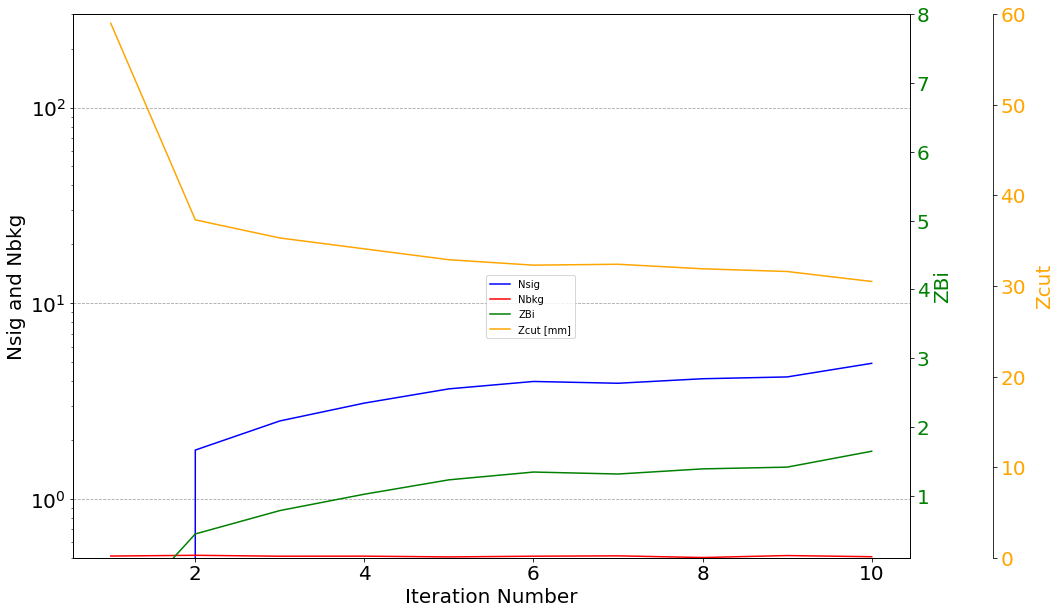

In [160]:
    xvalues = [i+1 for i in range(len(zbis))]
    fig, ax = plt.subplots(figsize=(15,10))
    #fig, ax = plt.subplots()
    ax.plot(xvalues, nsigs, label='Nsig',color='blue')
    ax.plot(xvalues, nbkgs, label='Nbkg',color='red')
    ax.set_yscale('log')
    ax.set_ylabel('Nsig and Nbkg', fontsize = 20)
    ax.set_xlabel("Iteration Number", fontsize = 20)
    ax.tick_params(axis='y', labelsize = 20)
    ax.tick_params(axis='x', labelsize = 20)
    ax.set_ylim(bottom=0.5, top=300)
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)

    ax2 = ax.twinx()
    ax2.plot(xvalues, zbis, label='ZBi',color='green')
    ax2.set_ylabel('ZBi', color='green', fontsize = 20)
    ax2.tick_params(axis='y',labelcolor='green', labelsize = 20)
    ax2.set_ylim(bottom=0.1, top=8)
    #ax2.text(1,6,f'zalpha_slope_{zalpha_slope}')
    
    ax3 = ax.twinx()
    ax3.plot(xvalues, zcuts, label='Zcut [mm]',color='orange')
    ax3.set_ylabel('Zcut', color='orange', fontsize = 20)
    ax3.yaxis.set_label_coords(1.15, 0.5)  
    ax3.tick_params(axis='y',labelcolor='orange', labelsize = 20)
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.set_ylim(bottom=0.0, top=60.0)
    
    fig.legend(loc='center')
    with PdfPages(f'{outdir}/mass_{mass}_v0projsig.pdf') as pdf:
        #fig.axes[0].set_ylim(bottom=1,top=10000000)
        pdf.savefig(fig)

    #Save data as TGraphs
    graphs = {}
    graphs['nsig'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(nsigs,dtype=float))
    graphs['nbkg'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(nbkgs,dtype=float))
    graphs['zbis'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(zbis,dtype=float))
    graphs['zcuts'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(zcuts,dtype=float))
    graphs['cut_values'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(cut_values,dtype=float))
    graphs['eff'] = r.TGraph(len(xvalues), np.array(xvalues,dtype=float), np.array(effs,dtype=float))
    for key, graph in graphs.items():
        outfile[f'{key}_g'] = graph